# Lotka-Volterra Dynamics

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import bayesflow as bf

import keras

INFO:2025-11-17 10:00:27,339:jax._src.xla_bridge:822: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:bayesflow:Using backend 'jax'


In [2]:
import sys
sys.path.append("../")

from helpers import plot_lv_trajectores, expert_stats

In [3]:
# avoid scientific notation for outputs
np.set_printoptions(suppress=True)

## Ecology Simulator

Suppose we measured population counts from two species over time. One of them preys on the other, so we might assume that the dynamics are governed by the classic Lotka-Volterra system.

In dimensionless form, with prey population $x$ and predator population $y$, the nonlinear differential equation is

$$
\begin{aligned}{\frac {dx}{dt}}&=\alpha x-\beta xy,\\{\frac {dy}{dt}}&=-\gamma y+\delta xy.\end{aligned}
$$

As always, this model entails a number of assumptions that can only be approximate. In brief:

- On their own, prey count increases exponentially with rate $\alpha$, while predator count decays with rate $\gamma$.
- Interesting dynamics are possible when both predators and prey are present: The number of predators increases the more prey it can hunt, reducing prey counts proportionally at a rate $\beta$ and increasing predator count proportionally at a rate $\delta$.
- We can measure population timeseries, but never the parameters directly, so this is a scientifically relevant inverse problem.

The Lotka-Volterra equations alone are not yet a precise, falsifiable model, since they do not predict anything measureable. We must pick parameters, initial conditions, and an observation model which describes how (noisy) measurements take place. The wide applicability of simulation-based inference is due to the fact that **scientific hypotheses typically come in the form of simulators of measurable quantities**.

Our simulator will consist of three parts:
1. First, we choose a prior distribution over parameters that reflects our beliefs about parameters before observing data.
2. Building on parameters sampled from the prior, we solve the parameterized Lotka-Volterra equation starting from some initial conditions.
3. Finally, we hypothesize that we will make some counting errors when observing the populations, introducing a Gaussian error on the true populations.

A random number generator with a fixed seed will ensure reproducibility of the simulated training and validation data.

In [4]:
rng = np.random.default_rng(seed=2025)

In [5]:
def prior():
    x = rng.normal(size=4)
    # logit normal distribution scaled to range from 0.1 and 4
    theta = 1/(1+np.exp(-x)) * 3.9 + 0.1 
    return dict(
        alpha=theta[0],
        beta=theta[1],
        gamma=theta[2],
        delta=theta[3],
    )


def lotka_volterra_equations(state, t, alpha, beta, gamma, delta):
    x, y = state
    dxdt = alpha * x - beta * x * y
    dydt = - gamma * y + delta * x * y
    return [dxdt, dydt]


def ecology_model(alpha, beta, gamma, delta, t_span=[0, 5], t_steps=100, initial_state=[1, 1]):
    t = np.linspace(t_span[0], t_span[1], t_steps)
    state = odeint(lotka_volterra_equations, initial_state, t, args=(alpha, beta, gamma, delta))
    x, y = state.T
    
    return dict(
        x=x,  # Prey time series
        y=y,  # Predator time series
        t=t,  # Time vector
    )


def observation_model(x, y, t, subsample=10, obs_prob=1.0, noise_scale=0.1):
    t_steps = x.shape[0]
    
    # Add Gaussian noise to observations
    noisy_x = rng.normal(x, noise_scale)
    noisy_y = rng.normal(y, noise_scale)
    
    # Determine which time steps are observed
    step_indices = np.arange(0, t_steps, subsample)
    num_observed = int(obs_prob * len(step_indices))
    observed_indices = np.sort(rng.choice(step_indices, num_observed, replace=False))

    return {
        "observed_x": noisy_x[observed_indices],
        "observed_y": noisy_y[observed_indices],
        "observed_t": t[observed_indices]
    }

In [6]:
p = prior()
p

{'alpha': 0.48164641056373625,
 'beta': 2.075348233437099,
 'gamma': 1.5368670432270386,
 'delta': 1.052809398167223}

In [7]:
observation_model(**ecology_model(**p))

{'observed_x': array([0.75581334, 0.36169536, 0.56944328, 0.44004584, 0.44921465,
        0.62785572, 0.36257802, 0.81612008, 0.88862044, 0.87738167]),
 'observed_y': array([ 1.07164387,  0.5892121 ,  0.54888111,  0.29705669,  0.03348947,
         0.14288611, -0.06268263,  0.15279859,  0.0750439 ,  0.19735671]),
 'observed_t': array([0.        , 0.50505051, 1.01010101, 1.51515152, 2.02020202,
        2.52525253, 3.03030303, 3.53535354, 4.04040404, 4.54545455])}

We can combine these three components into a BayesFlow simulator via:

In [8]:
simulator = bf.make_simulator(
    [prior, ecology_model, observation_model]
)

In [9]:
simulator.sample(2)["x"].shape

(2, 100)

Let's sample 100 trajectories, and see what we get:

In [10]:
num_trajectories = 80
samples = simulator.sample(num_trajectories)
keras.tree.map_structure(keras.ops.shape, samples)

{'alpha': (80, 1),
 'beta': (80, 1),
 'gamma': (80, 1),
 'delta': (80, 1),
 'x': (80, 100),
 'y': (80, 100),
 't': (80, 100),
 'observed_x': (80, 10),
 'observed_y': (80, 10),
 'observed_t': (80, 10)}

What types of developments (and observations) does our Lotka-Volterra simulator predict? We should have a function to visualize sampled trajectories and take a look!

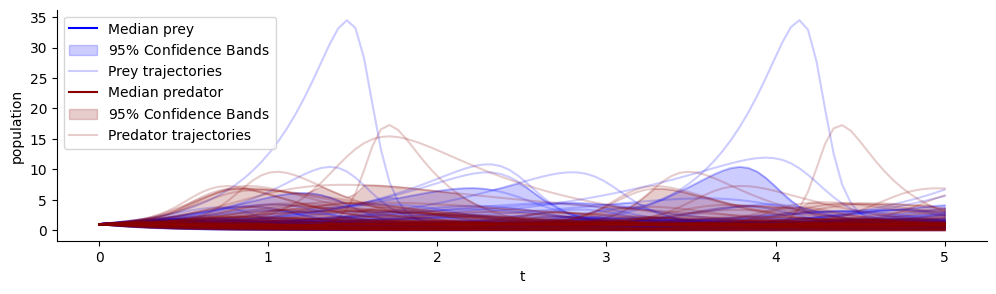

In [11]:
plot_lv_trajectores(samples, ["x", "y"], ["Prey", "Predator"], num_to_plot=80)

Above, we cen see how to access the *prior predictive distribution* of the simulator. The shaded area contains 95% of trajectories at each timestep, additionally we see a few example trajectories.

Predator and prey populations generally oscillate in this model, but the frequency, amplitude, relative lag, and scale varies greatly for different parameters.

The prior predictive distribution should match our expectation of the real world system of interest before we take into account concrete observed population counts.
Here, we see the prior implies population magnitudes to oscillate (mostly) below 6.

## Domain Expert Statistics

Ultimately, we want to learn maximally informative summary statistics jointly with an amortized posterior approximation, but hand crafted summary statistics have the benefit of being interpretable and fast to compute. Oftentimes, there are a few natural and established statistics for a particular modality of raw data. Domain experts are likely to have made significant progress in finding closed form expressions or algorithms for informative summaries.

Compared to the *sufficient summary statistics*, we can expect there to be less posterior contraction.

Still, we can reasonably expect that oscillation period, mean, (log) variance, autocorrelation at different lags of both trajectories, and the cross correlation between the two trajectories are highly informative when taken together as summary statistics.

To compute the expert statistics we can append the `expert_stats` function to the `simulator` object.

In [12]:
simulator = bf.make_simulator([prior, ecology_model, observation_model, expert_stats])

In [13]:
samples_with_expert_stats = simulator.sample(3)

keras.tree.map_structure(keras.ops.shape, samples_with_expert_stats)

{'alpha': (3, 1),
 'beta': (3, 1),
 'gamma': (3, 1),
 'delta': (3, 1),
 'x': (3, 100),
 'y': (3, 100),
 't': (3, 100),
 'observed_x': (3, 10),
 'observed_y': (3, 10),
 'observed_t': (3, 10),
 'means': (3, 2),
 'log_vars': (3, 2),
 'auto_corrs': (3, 4),
 'cross_corr': (3, 1),
 'period': (3, 1)}

Let us now generate training and validation data for our amortized setup. Below, we will demonstrate *offline training* on a relatively small set of $B = 5000$ simulations.

In [14]:
training_data = simulator.sample(5000)
validation_data = simulator.sample(300)

## Posterior Approximation with Hand-Crafted Summary Statistics

### Inference Network


Flow Matching is a technique for training neural ODEs (ordinary differential equations) to learn continuous-time dynamics that transform a simple base distribution (e.g., a Gaussian) into a target distribution (e.g., a posterior over simulator parameters). It can be seen as a reparameterization of score-based diffusion models.

At its core, Flow Matching learns a velocity field $\mathbf{v}_\theta(\theta; y, t)$ such that trajectories starting from the base distribution transform into samples from the target distribution over a fixed time interval (typically $t \in [0, 1]$).

In [15]:
flow = bf.networks.CouplingFlow(depth=2, transform="spline")

### Adapter

To ensure that the training data generated by the simulator can be used for deep learning in the way you intend, you can apply any number of transformations via `adapter` objects. They provides multiple flexible functionalities, from standardization to renaming, and so on.

BayesFlow provides default adapters that automate some of these steps, but for the purpose of this tutorial, we explicate the construction of the adapter. The only requirement for adapters is that the `inference_variables` key is present, indicating which variables are the inference targets.

In [16]:
par_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$"]

adapter = (
    bf.adapters.Adapter()

    # convert from numpy's default float64 to deep learning friendly float32
    .convert_dtype("float64", "float32")

    # drop unobserved full trajectories and raw observations (optional)
    .drop(["x", "y", "t", "observed_x", "observed_y", "observed_t"])

    # rename the variables to match the required approximator inputs
    .concatenate(["alpha", "beta", "gamma", "delta"], into="inference_variables")
    .concatenate(["means", "log_vars", "auto_corrs", "cross_corr", "period"], into="inference_conditions")

)
adapter

Adapter([0: ConvertDType -> 1: Drop(['x', 'y', 't', 'observed_x', 'observed_y', 'observed_t']) -> 2: Concatenate(['alpha', 'beta', 'gamma', 'delta'] -> 'inference_variables') -> 3: Concatenate(['means', 'log_vars', 'auto_corrs', 'cross_corr', 'period'] -> 'inference_conditions')])

### Basic Workflow and Training

In [17]:
workflow = bf.BasicWorkflow(
    adapter=adapter,
    inference_network=flow,
)

In [18]:
epochs = 50
batch_size = 32

In [ ]:
history = workflow.fit_offline(
    data=training_data, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=validation_data,
    checkpoint_filepath="test/"
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: -0.0342 - val_loss: -0.2112
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0234 - val_loss: -0.3899
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0669 - val_loss: -0.4283
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0280 - val_loss: -0.4525
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -0.0314 - val_loss: -0.4755
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: -0.0758 - val_loss: -0.5545
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -0.1455 - val_loss: -0.6397
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -0.1928 - val_loss: -0.4392
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -0.1996 - val_loss: -0.6305
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -0.2574 - val_loss: -0.7355
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -0.3204 - val_loss: -0.6553
Epoch 12/50
157/157 ━━━━━━━━━━━━

KeyboardInterrupt: 

### Convergence, Sampling, and Diagnostics

#### Loss Trajectory

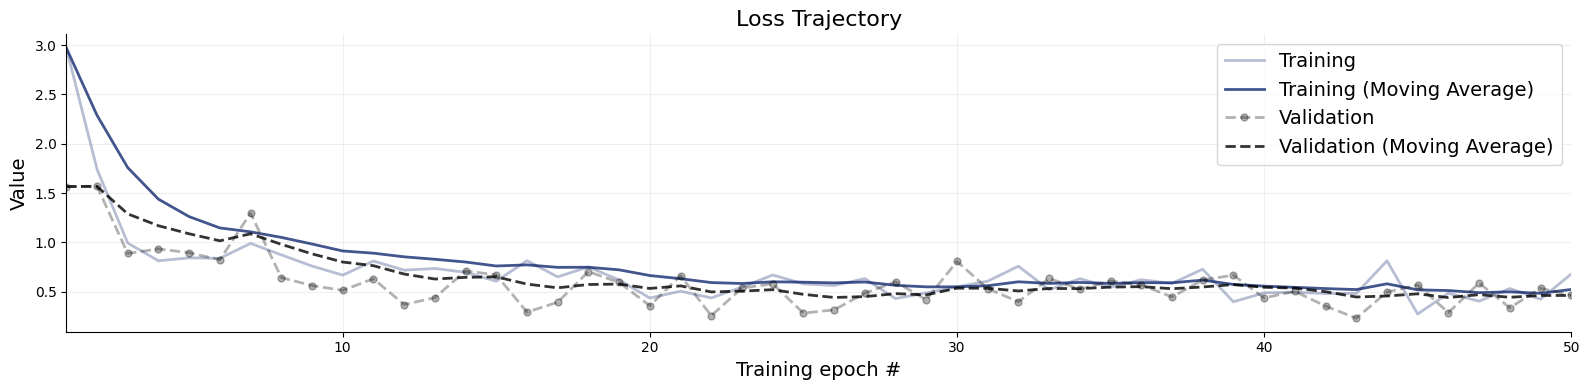

In [18]:
f = bf.diagnostics.loss(history)

In [21]:
# Set the number of posterior draws you want to get
num_samples = 2000

# Obtain posterior draws with the sample method (shortcut for workflow.approximator.sample...)
post_draws = workflow.sample(conditions=validation_data, num_samples=num_samples)

#### Point Recovery

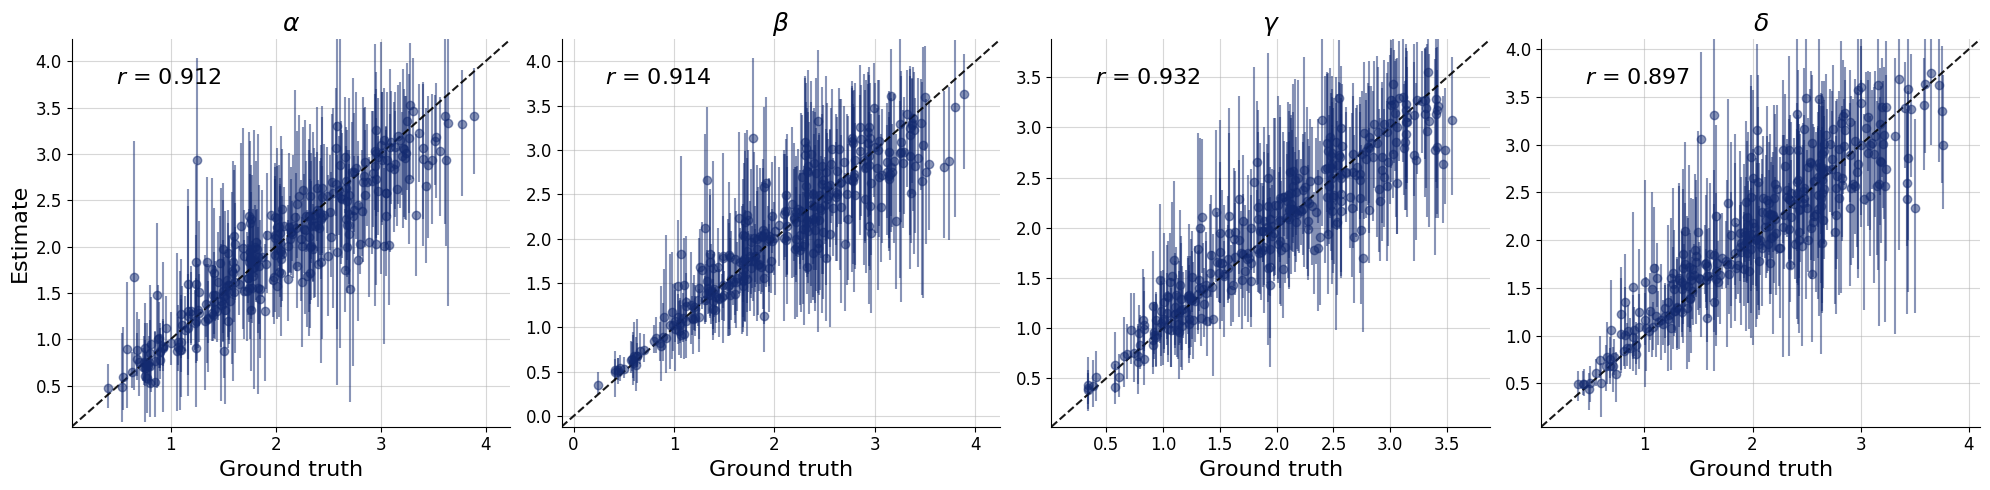

In [22]:
fig = bf.diagnostics.plots.recovery(estimates=post_draws, targets=validation_data, variable_names=par_names)

#### Simulation-Based Calibration

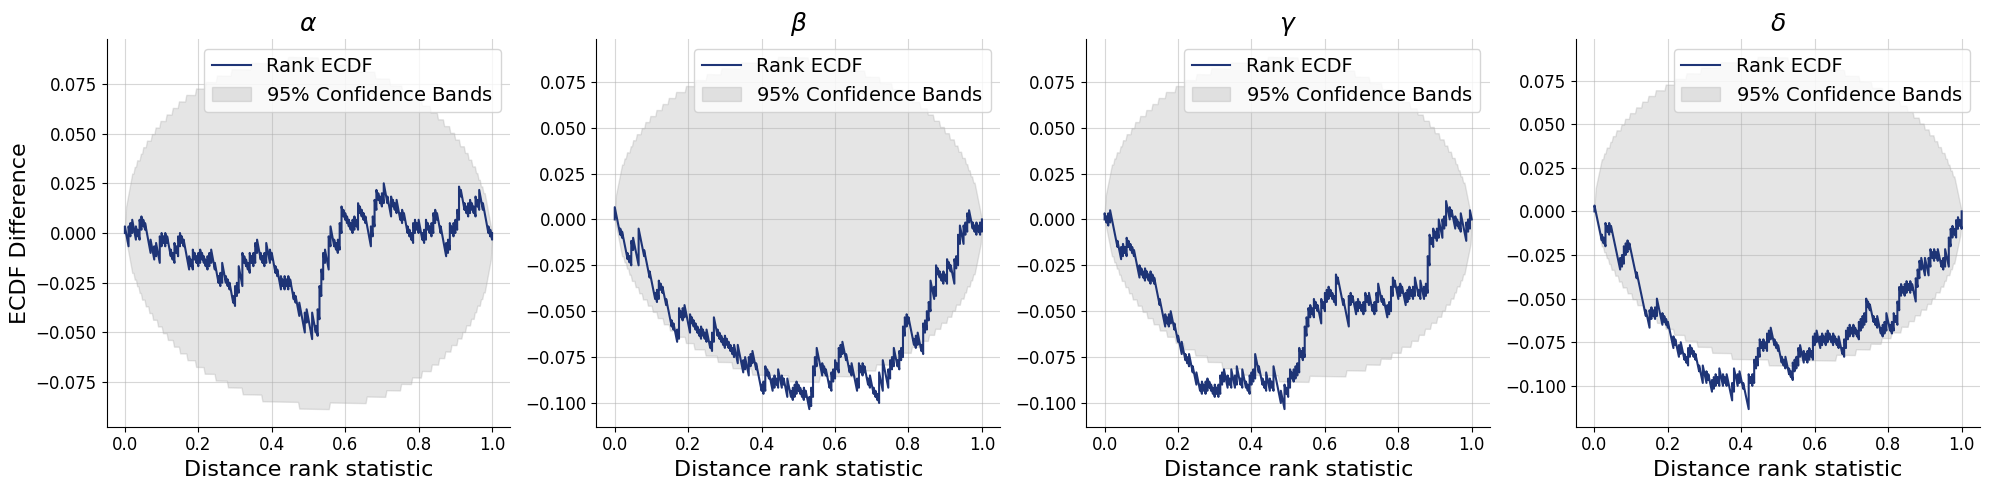

In [22]:
fig = bf.diagnostics.plots.calibration_ecdf(
    estimates=post_draws, 
    targets=validation_data,
    variable_names=par_names,
    difference=True,
    rank_type="distance"
)

#### Posterior Z-Score vs. Contraction

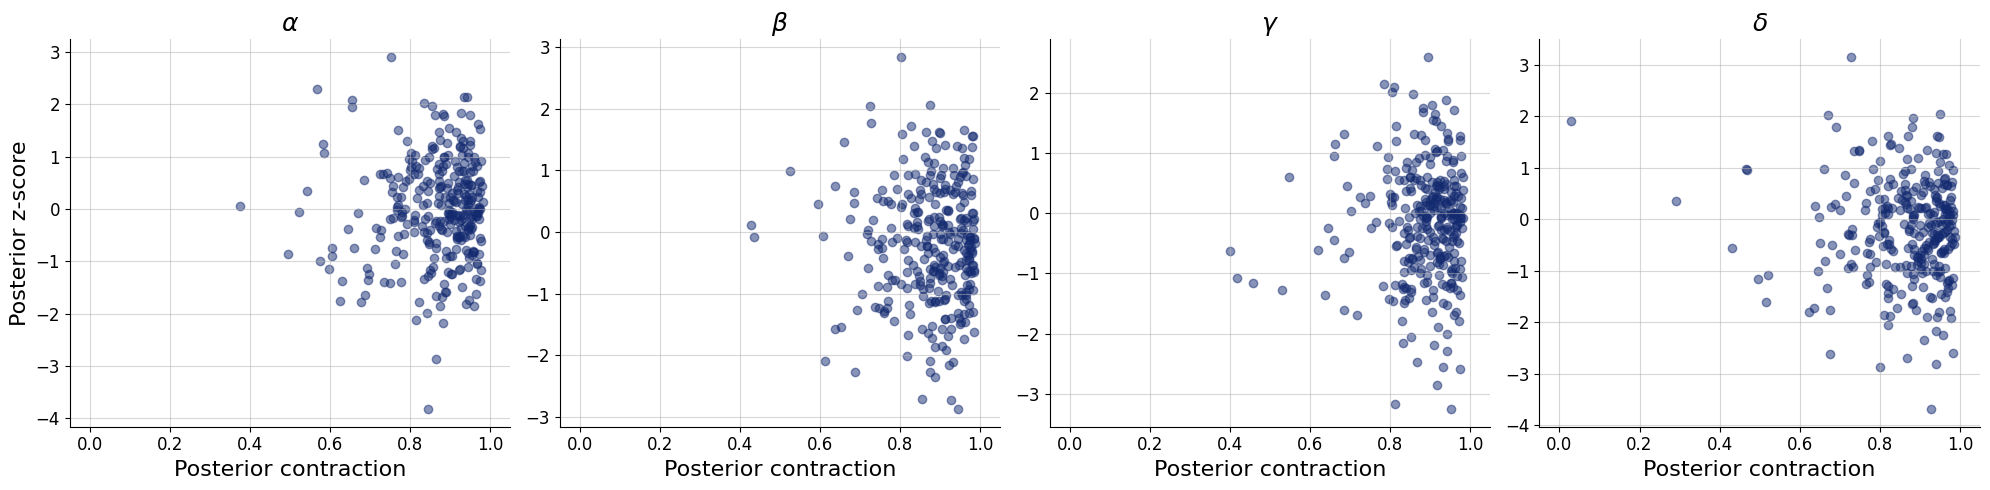

In [23]:
fig = bf.diagnostics.plots.z_score_contraction(
    estimates=post_draws, 
    targets=validation_data,
    variable_names=par_names
)

#### Marginal and Bivariate Posteriors

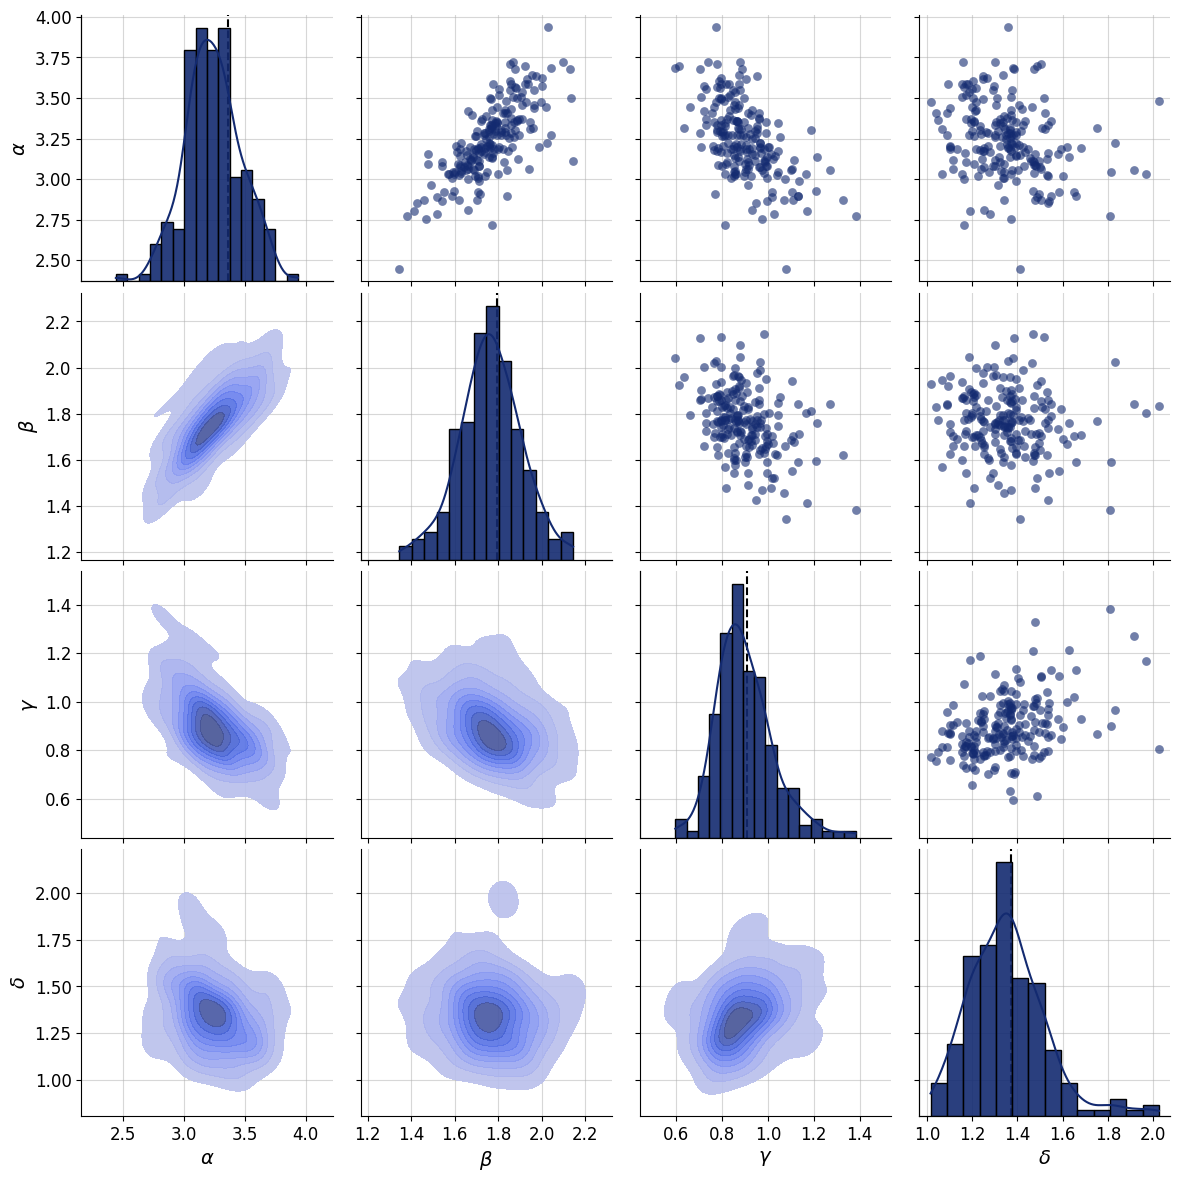

In [24]:
g = bf.diagnostics.plots.pairs_posterior(
    estimates=post_draws, 
    targets=validation_data,
    dataset_id=0,
    variable_names=par_names,
)

#### Posterior Retrodictive and Predictive Checks

In [25]:
def take_posterior_sample(post_draws, dataset_id, sample_id):
    """Helper function to return a single sample for a single data set."""
    posterior_sample_for_id = {var_key: post_draws[var_key][dataset_id, sample_id,...].squeeze() for var_key in post_draws.keys()}
    return posterior_sample_for_id

def take_dataset(sims, dataset_id):
    """Helper function to return a single simulation from a dictionary of simulations."""
    return {var_key: sims[var_key][dataset_id] for var_key in sims.keys()}

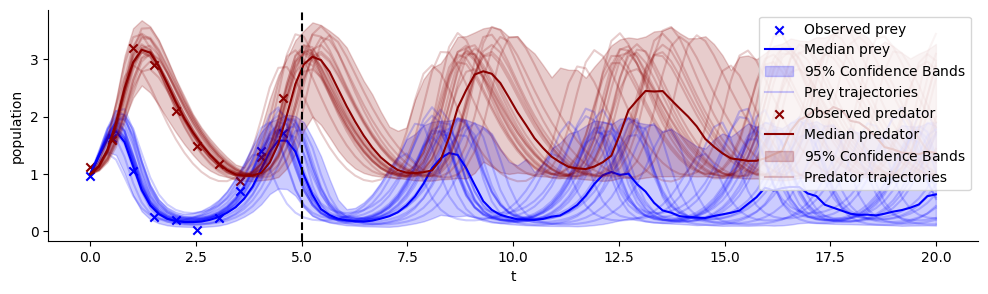

In [26]:
dataset_id = 0

list_of_resimulations = []

for sample_id in range(num_samples):
    one_post_sample = take_posterior_sample(post_draws, dataset_id, sample_id)
    list_of_resimulations.append(ecology_model(t_span=[0,20], **one_post_sample))

resimulation_samples = bf.utils.tree_stack(list_of_resimulations, axis=0)

observations = take_dataset(validation_data, dataset_id)


f, ax = plt.subplots(1, 1, figsize=(12, 3))
plot_lv_trajectores(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations, ax=ax)
ax.axvline([5], color="black", linestyle="dashed")

## End-To-End Learning of Summary Statistics

Next, we will move away from hand-crafted summary statistics, using an auxilliary network to learn the most informative statistics on the fly.

### Updated Adapter

In [ ]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .drop(["x", "y", "t"])
    .drop(["means", "log_vars", "auto_corrs", "cross_corr", "period"])
    .as_time_series(["observed_x", "observed_y", "observed_t"])
    .concatenate(["alpha", "beta", "gamma", "delta"], into="inference_variables")

    # Notice that we now use 'summary_variables' to indicate that these quantities will
    # be passed to the summary network before being used as a condition
    .concatenate(["observed_x", "observed_y", "observed_t"], into="summary_variables")
)
adapter

Adapter([0: ConvertDType -> 1: Drop(['x', 'y', 't']) -> 2: Drop(['means', 'log_vars', 'auto_corrs', 'cross_corr', 'period']) -> 3: AsTimeSeries -> 4: Concatenate(['alpha', 'beta', 'gamma', 'delta'] -> 'inference_variables') -> 5: Concatenate(['observed_x', 'observed_y', 'observed_t'] -> 'summary_variables') -> 6: Standardize(include=['inference_variables', 'summary_variables'])])

In [28]:
e2e_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=bf.networks.TimeSeriesNetwork(),
    inference_network=bf.networks.FlowMatching()
)

In [29]:
%%time
history = e2e_workflow.fit_offline(
    data=training_data, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 2.2687 - loss/inference_loss: 2.2687 - val_loss: 1.1400 - val_loss/inference_loss: 1.1400
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3590 - loss/inference_loss: 1.3590 - val_loss: 1.6073 - val_loss/inference_loss: 1.6073
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1653 - loss/inference_loss: 1.1653 - val_loss: 1.2869 - val_loss/inference_loss: 1.2869
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0670 - loss/inference_loss: 1.0670 - val_loss: 1.1473 - val_loss/inference_loss: 1.1473
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9842 - loss/inference_loss: 0.9842 - val_loss: 0.6690 - val_loss/inference_loss: 0.6690
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9405 - loss/inference_loss: 0.9405 - val_loss: 0.9953 - val_loss/inference_loss: 0.9953
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9115 - loss/inference_loss: 0.911

### Convergence, Sampling, and Diagnostics

#### Loss Trajectory

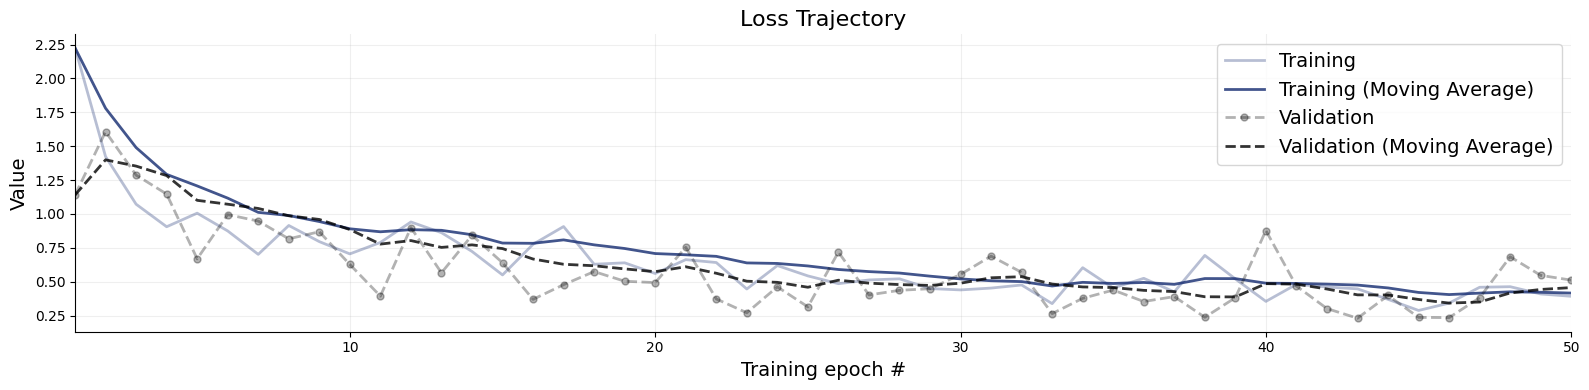

In [32]:
history = bf.diagnostics.plots.loss(history)

Note, that the loss is lower since we are learning summary statistics simultaneously. How does this translate to visual diagnostics? We can check them again by sampling the posteriors of validation simulations not seen in training.

In [33]:
samples = e2e_workflow.sample(num_samples=250, conditions=validation_data)

#### Point Recovery

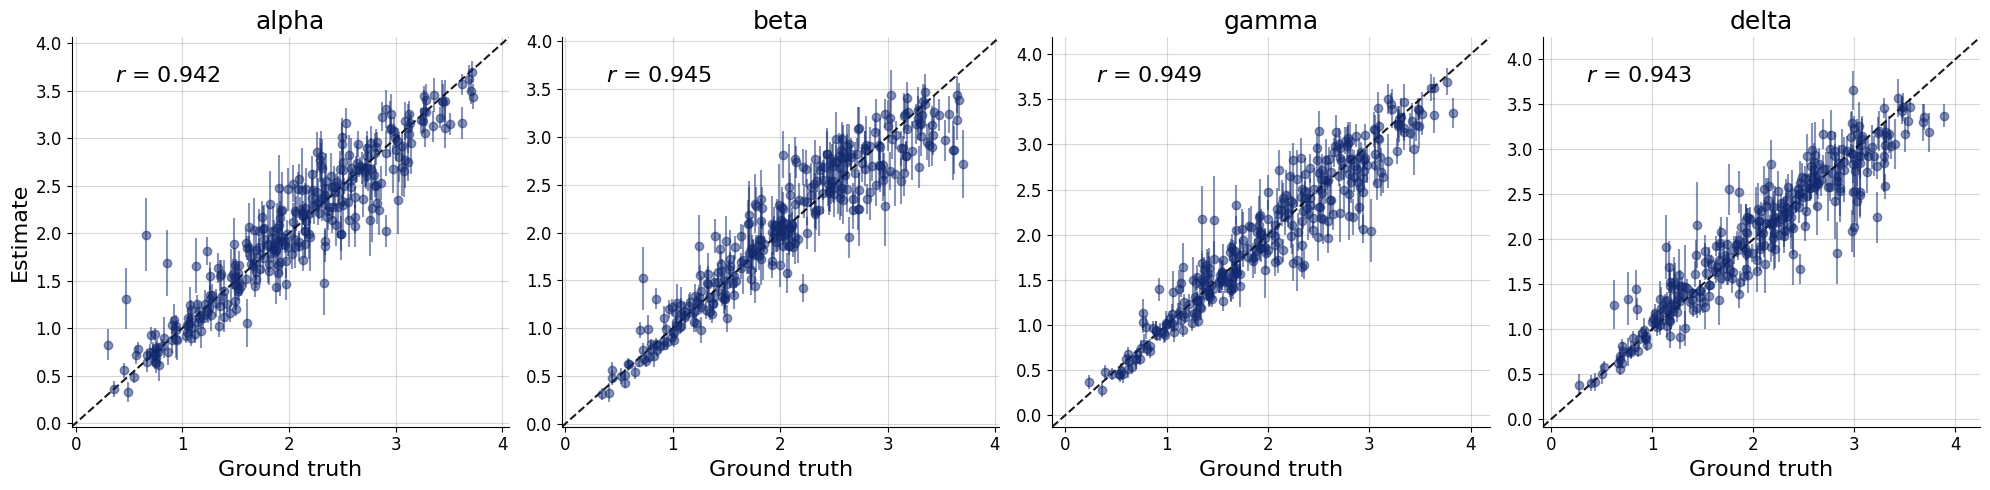

In [34]:
f = bf.diagnostics.plots.recovery(
    estimates=samples, 
    targets=validation_data
)

#### Simulation-Based Calibration

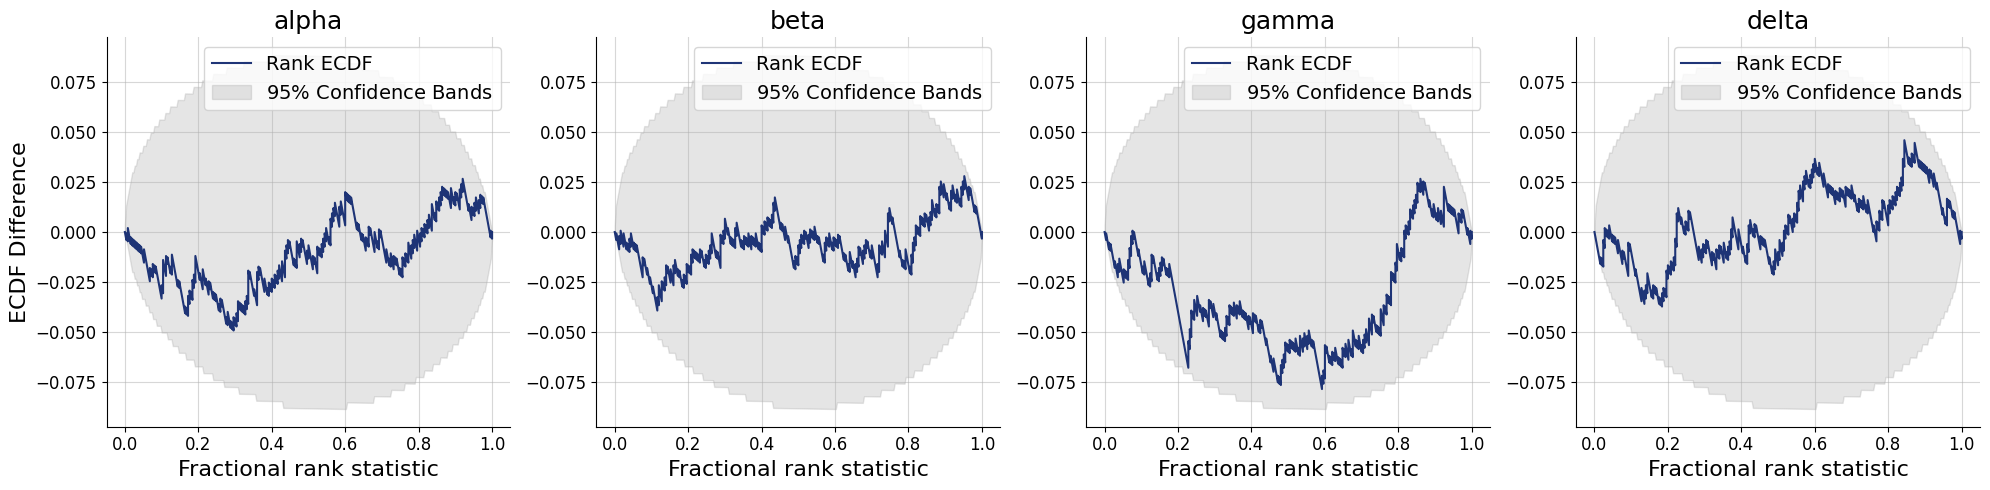

In [36]:
f = bf.diagnostics.plots.calibration_ecdf(
    estimates=samples, 
    targets=validation_data,
    difference=True 
)

#### Marginal and Bivariate Posteriors

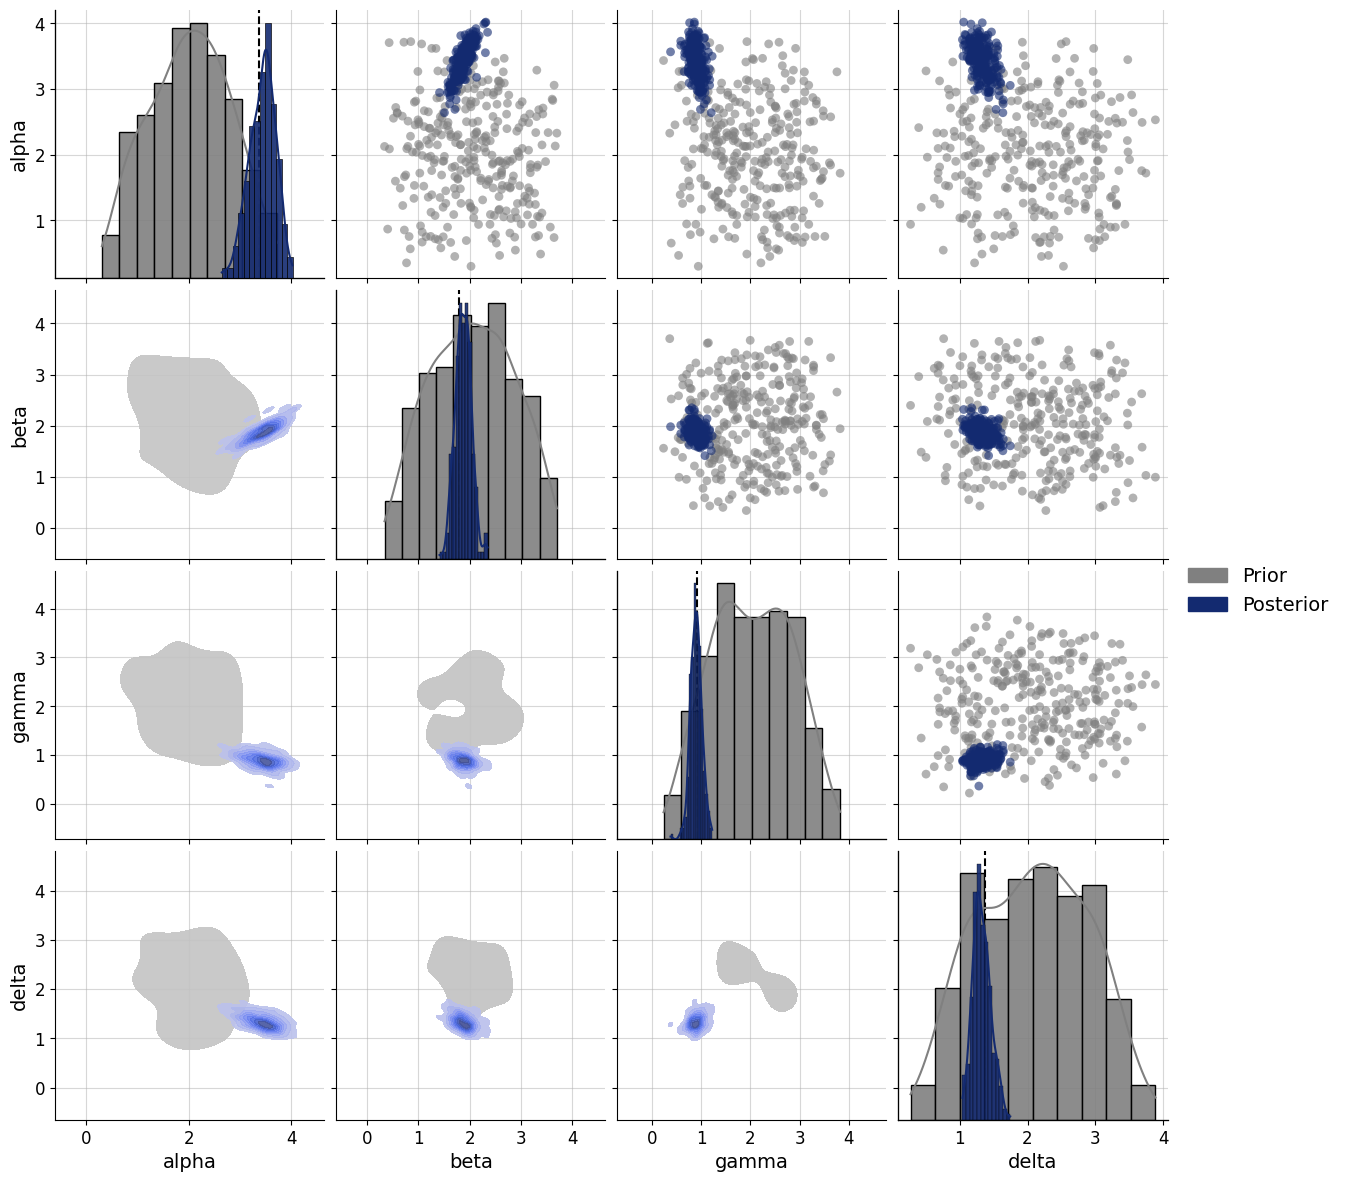

In [39]:
f = bf.diagnostics.plots.pairs_posterior(
    estimates=samples, 
    targets=validation_data,
    dataset_id=0,
    priors=validation_data
)

#### Posterior Retrodictive and Predictive Checks

In [40]:
post_draws = samples

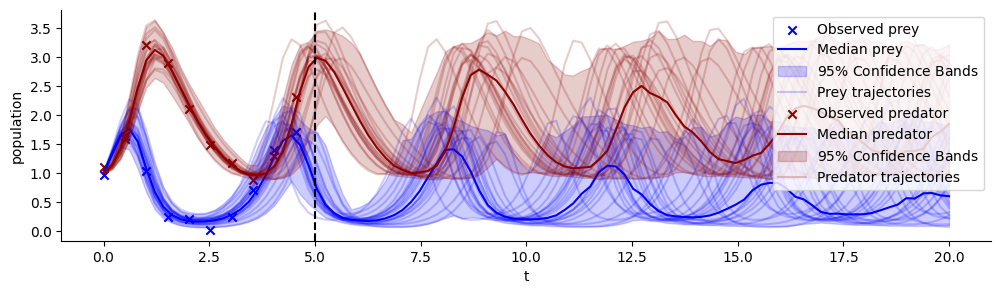

In [41]:
dataset_id = 0

list_of_resimulations = []

for sample_id in range(num_samples):
    one_post_sample = take_posterior_sample(post_draws, dataset_id, sample_id)
    list_of_resimulations.append(ecology_model(t_span=[0,20], **one_post_sample))

resimulation_samples = bf.utils.tree_stack(list_of_resimulations, axis=0)

observations = take_dataset(validation_data, dataset_id)


f, ax = plt.subplots(1, 1, figsize=(12, 3))
plot_lv_trajectores(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations, ax=ax)
ax.axvline([5], color="black", linestyle="dashed")

## Comparing Workflows at a Glance

In [30]:
diag = workflow.compute_default_diagnostics(validation_data, num_samples=500)
diag

,alpha,beta,gamma,delta
NRMSE,0.121168,0.120879,0.108853,0.120997
Posterior Contraction,0.893647,0.891465,0.903410,0.894071
Calibration Error,0.015439,0.009561,0.028246,0.013509


In [31]:
e2e_diag = e2e_workflow.compute_default_diagnostics(validation_data, num_samples=500)
e2e_diag

,alpha,beta,gamma,delta
NRMSE,0.112403,0.115274,0.104116,0.108834
Posterior Contraction,0.908381,0.898962,0.919787,0.918580
Calibration Error,0.028246,0.015965,0.015965,0.019737
